# Cosmos DB Gaming App Simulation

This notebook demonstrates how to build a backend for an online gaming application using Azure Cosmos DB NoSQL API.

## Objectives
- Provision Cosmos DB containers for players, sessions, matches, events, and leaderboards.
- Simulate hundreds of users across multiple regions.
- Stream gameplay events and update leaderboards.
- Query top-K leaderboard results.
- Demonstrate change feed for live ops.
- Retrieval-Augmented Generation (RAG) with Azure Cosmos DB Core API for Gaming Collections

## Prerequisites
- Azure Cosmos DB NoSQL account with multi-region setup.
- Python 3.9+ environment with Jupyter Notebook.
- Cosmos DB endpoint, Open AI endpoint and key.


## Setup: Install dependencies and configure Cosmos DB connection

In [ ]:
%pip install --quiet azure-cosmos==4.* faker numpy

In [28]:
import os, hashlib, time, random, uuid, json
from datetime import datetime, timedelta, timezone
from concurrent.futures import ThreadPoolExecutor, as_completed
from faker import Faker
from azure.cosmos import CosmosClient, PartitionKey, ThroughputProperties, exceptions
from dotenv import dotenv_values
from azure.identity import DefaultAzureCredential

env_name = "./config/config.env" # using config.env template, change to your own .env file name
config = dotenv_values(env_name)

COSMOS_ENDPOINT = config['NOSQL_ENDPOINT']
DB_NAME = "gamingdb"
credential = DefaultAzureCredential()


REGIONS = ["Southeast Asia", "East US", "West US", "Japan East", "Australia East", "Central India"]


primary = CosmosClient(COSMOS_ENDPOINT, credential=credential, consistency_level="Session", preferred_locations=REGIONS)

region_clients = {
    r: CosmosClient(COSMOS_ENDPOINT, credential=credential, consistency_level="Session", preferred_locations=[r])
    for r in REGIONS
}


## Provisioning: Create database and containers

In [29]:
autoscale_throughput = ThroughputProperties(auto_scale_max_throughput=2000)

db = primary.create_database_if_not_exists(id=DB_NAME, offer_throughput=autoscale_throughput)

players = db.create_container_if_not_exists(id="players", partition_key=PartitionKey(path="/playerId"))

sessions = db.create_container_if_not_exists(id="sessions", partition_key=PartitionKey(path="/sessionId"), default_ttl=86400)

matches = db.create_container_if_not_exists(id="matches", partition_key=PartitionKey(path="/matchId"))

events = db.create_container_if_not_exists(id="events", partition_key=PartitionKey(path="/matchId"), default_ttl=2592000)

leaderboards = db.create_container_if_not_exists(
    id="leaderboards",
    partition_key=PartitionKey(path="/leaderboardBucket"),
    unique_key_policy={"uniqueKeys": [{"paths": ["/leaderboardId", "/playerId"]}]}
)


## Helper Functions: Leaderboard bucketing and RU tracking

In [30]:
fake = Faker()

def leaderboard_bucket(leaderboard_id, player_id, buckets=32):
    h = int(hashlib.sha1(player_id.encode("utf-8")).hexdigest(), 16)
    b = h % buckets
    return f"{leaderboard_id}#{b:02d}"

_ru_log = {"writes":0.0, "reads":0.0, "patches":0.0}
def _ru_hook(headers):
    try:
        ru = float(headers.get("x-ms-request-charge","0"))
    except Exception:
        pass


## Data Seeding: Generate synthetic players across regions

In [31]:
N_PLAYERS = 600
players_seed = []

for i in range(N_PLAYERS):
    pid = str(uuid.uuid4())
    region = random.choice(REGIONS)
    players_seed.append({
        "id": pid, "playerId": pid,
        "gamertag": fake.user_name() + str(random.randint(10,99)),
        "mmr": random.randint(800, 2400),
        "homeRegion": region,
        "createdUtc": datetime.now(timezone.utc).isoformat()
    })

def _upsert_player(doc):
    try:
        c = region_clients[doc["homeRegion"]].get_database_client(DB_NAME).get_container_client("players")
        c.upsert_item(doc, response_hook=lambda h: _ru_hook(h))
        return True
    except Exception:
        return False

with ThreadPoolExecutor(max_workers=64) as ex:
    list(as_completed([ex.submit(_upsert_player, p) for p in players_seed]))


## Simulation: Concurrent gameplay across regions

In [32]:
SEASON = "2025-09"
MODES = ["solo","duo","squad"]

def ensure_leaderboard_entry(lb_container, leaderboard_id, player):
    bucket = leaderboard_bucket(leaderboard_id, player["playerId"])
    doc_id = f"{leaderboard_id}:{player['playerId']}"
    try:
        lb_container.upsert_item({
            "id": doc_id,
            "leaderboardId": leaderboard_id,
            "leaderboardBucket": bucket,
            "playerId": player["playerId"],
            "gamertag": player["gamertag"],
            "region": player["homeRegion"],
            "mode": leaderboard_id.split(":")[0],
            "season": leaderboard_id.split(":")[1],
            "score": 0,
            "lastUpdatedUtc": datetime.now(timezone.utc).isoformat()
        })
    except Exception:
        pass
    return doc_id, bucket

def simulate_player_session(player, events_per_match=10):
    region = player["homeRegion"]
    cli = region_clients[region]
    db_cli = cli.get_database_client(DB_NAME)
    sess_c = db_cli.get_container_client("sessions")
    match_c = db_cli.get_container_client("matches")
    events_c = db_cli.get_container_client("events")
    lb_c = db_cli.get_container_client("leaderboards")

    sid = str(uuid.uuid4())
    sess_c.create_item({
        "id": sid, "sessionId": sid,
        "playerId": player["playerId"],
        "region": region, "startedUtc": datetime.now(timezone.utc).isoformat()
    })

    mode = random.choice(MODES)
    match_id = str(uuid.uuid4())
    match = {
        "id": match_id, "matchId": match_id,
        "mode": mode, "region": region,
        "participants": [player["playerId"]],
        "startedUtc": datetime.now(timezone.utc).isoformat()
    }
    match_c.create_item(match)

    leaderboard_id = f"{mode}:{SEASON}"
    lb_doc_id, lb_pk = ensure_leaderboard_entry(lb_c, leaderboard_id, player)

    total = 0
    for n in range(events_per_match):
        points = random.choice([5,10,15,20,25])
        total += points
        ev = {
            "id": str(uuid.uuid4()),
            "matchId": match_id,
            "playerId": player["playerId"],
            "eventType": random.choice(["kill","assist","objective","loot"]),
            "points": points,
            "timestampUtc": datetime.now(timezone.utc).isoformat()
        }
        events_c.create_item(ev)

        try:
            lb_c.patch_item(
                item=lb_doc_id,
                partition_key=lb_pk,
                patch_operations=[
                    {"op":"incr","path":"/score","value":points},
                    {"op":"set","path":"/lastUpdatedUtc","value":datetime.now(timezone.utc).isoformat()}
                ]
            )
        except exceptions.CosmosHttpResponseError:
            doc = lb_c.read_item(lb_doc_id, partition_key=lb_pk)
            doc["score"] = doc.get("score",0) + points
            doc["lastUpdatedUtc"] = datetime.now(timezone.utc).isoformat()
            lb_c.upsert_item(doc)

    sess_c.upsert_item({
        "id": sid, "sessionId": sid, "playerId": player["playerId"],
        "region": region, "endedUtc": datetime.now(timezone.utc).isoformat()
    })
    return total

random.shuffle(players_seed)
SIM_USERS = 500
EVENTS_PER_MATCH = 8

t0 = time.time()
with ThreadPoolExecutor(max_workers=128) as ex:
    futures = [ex.submit(simulate_player_session, p, EVENTS_PER_MATCH) for p in players_seed[:SIM_USERS]]
    totals = [f.result() for f in as_completed(futures)]
t1 = time.time()
print(f"Simulated {SIM_USERS} users across {len(REGIONS)} regions in {t1-t0:.1f}s")


Simulated 500 users across 6 regions in 58.2s


## Query: Retrieve top-K leaderboard results

In [33]:
mode = "solo"
leaderboard_id = f"{mode}:{SEASON}"

query = '''
SELECT c.playerId, c.gamertag, c.region, c.score
FROM c
WHERE c.leaderboardId = @lb
ORDER BY c.score DESC
OFFSET 0 LIMIT 15
'''

lb_cli = primary.get_database_client(DB_NAME).get_container_client("leaderboards")
results = list(lb_cli.query_items(
    query=query,
    parameters=[{"name":"@lb","value":leaderboard_id}],
    enable_cross_partition_query=True
))
print(json.dumps(results, indent=2)[:2000])


[
  {
    "playerId": "f6a680e8-aa0f-4271-a7fa-e8a3f7d4a20e",
    "gamertag": "regina9087",
    "region": "East US",
    "score": 185
  },
  {
    "playerId": "79abd22f-f668-4f8d-8ede-417018b4b915",
    "gamertag": "ojones43",
    "region": "Japan East",
    "score": 170
  },
  {
    "playerId": "7132fea4-ace2-4c1a-b030-95e0228f4645",
    "gamertag": "brandon6221",
    "region": "East US",
    "score": 170
  },
  {
    "playerId": "44e8cdab-4cb6-4074-bfed-b517d4009147",
    "gamertag": "williambowen23",
    "region": "Japan East",
    "score": 170
  },
  {
    "playerId": "dbce226b-18b1-4d17-8b79-07e42b81687d",
    "gamertag": "brentleon63",
    "region": "Southeast Asia",
    "score": 165
  },
  {
    "playerId": "6d1929db-5cb0-41d3-9431-7783a7d1d551",
    "gamertag": "michelle1361",
    "region": "Southeast Asia",
    "score": 165
  },
  {
    "playerId": "06a37ffc-c227-49fc-a828-149eafa53001",
    "gamertag": "rromero70",
    "region": "Australia East",
    "score": 160
  },
  {
   

## Change Feed: Pull recent events for live ops

In [ ]:
pager = events.query_items_change_feed(
    is_start_from_beginning=True,
    max_item_count=10
)

for page in pager.by_page():
    for doc in page:
        # process each changed document
        print(doc)


## Observability: RU logging

## Next Steps

- Add friends and clans containers.
- Materialize top-N leaderboards using change feed.
- Integrate with Azure Monitor for observability.
- Enable Synapse Link for analytics.


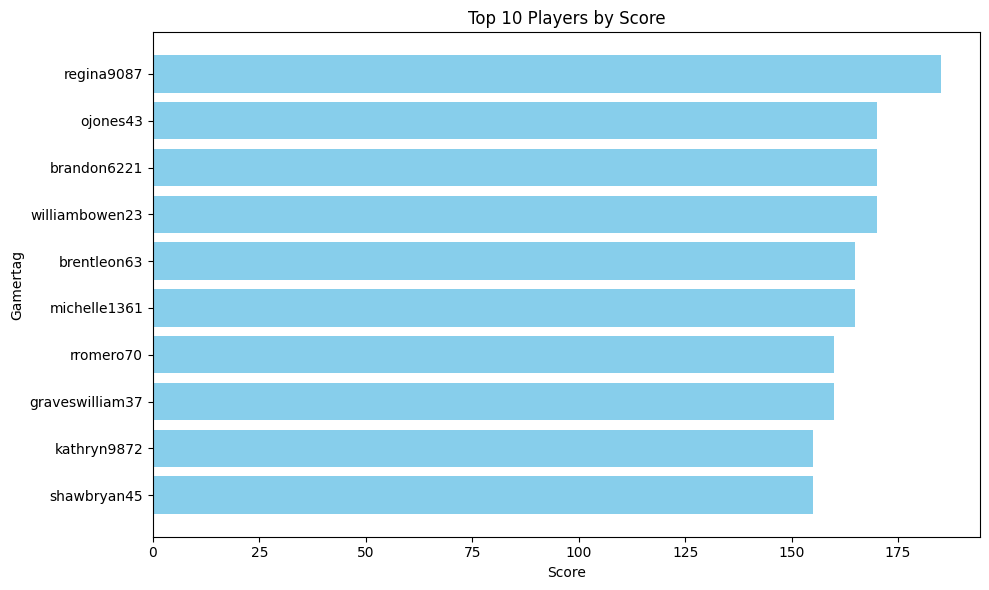

In [34]:

import matplotlib.pyplot as plt

# Extract top 10 players from previous query results
top_players = results[:10]
gamertags = [p["gamertag"] for p in top_players]
scores = [p["score"] for p in top_players]

# Reverse for highest score at top
gamertags = gamertags[::-1]
scores = scores[::-1]

# Plot horizontal bar chart
plt.figure(figsize=(10, 6))
plt.barh(gamertags, scores, color='skyblue')
plt.xlabel("Score")
plt.ylabel("Gamertag")
plt.title("Top 10 Players by Score")
plt.tight_layout()
plt.show()


# Retrieval-Augmented Generation (RAG) with Azure Cosmos DB Core API for Gaming Collections

This section demonstrates how to:
- Connect to Azure Cosmos DB Core (SQL) API
- Read sample documents from existing collections (`players`, `sessions`, `leaderboards`, `events`, `matches`)
- Generate embeddings using Azure OpenAI
- Store documents with embeddings in a new container with vector indexing
- Perform vector search queries for RAG scenarios

**Note:** Replace all placeholder values (endpoint, keys, etc.) with your actual credentials.

## Create `ragCollection` with Vector Indexing

This container will store documents with embeddings and enable vector search (HNSW + cosine, 1536 dimensions).

In [35]:
RAG_DB_NAME = "gamingRagDB"
RAG_CONTAINER_NAME = "ragCollection"

# Define vector indexing policy (requires preview feature enabled in your Cosmos DB account)
indexing_policy = {
    "indexingMode": "consistent",
    "automatic": True,
    "includedPaths": [
        {"path": "/*"}
    ],
    "vectorIndexes": [
        {
            "path": "/embedding",
            "type": "diskANN"
        }
    ]
}

vector_embedding_policy = {
    "vectorEmbeddings": [
        {
            "path": "/embedding",
            "dataType": "float32",
            "distanceFunction": "cosine",
            "dimensions": 1536
        }
    ]
}

try:
    ragdb_autoscale_throughput = ThroughputProperties(auto_scale_max_throughput=1000)
    rag_db = primary.create_database_if_not_exists(id=RAG_DB_NAME)
    rag_container = rag_db.create_container_if_not_exists(
        id=RAG_CONTAINER_NAME,
        partition_key=PartitionKey(path="/category"),
        offer_throughput=ragdb_autoscale_throughput,
        indexing_policy=indexing_policy,
        vector_embedding_policy=vector_embedding_policy
    )
    print(f"Container '{RAG_CONTAINER_NAME}' is ready.")
except Exception as e:
    print("Error creating container:", e)

Container 'ragCollection' is ready.


## Read Top 10 Documents from Each Gaming Collection

We will read up to 10 documents from each of the following collections:
- `players`
- `sessions`
- `leaderboards`
- `events`
- `matches`

In [36]:
import uuid
import json

collection_names = ["players", "sessions", "leaderboards", "events", "matches"]
sample_documents = []

for collection_name in collection_names:
    try:
        container = db.get_container_client(collection_name)
        query = "SELECT * FROM c OFFSET 0 LIMIT 10"
        items = list(container.query_items(query=query, enable_cross_partition_query=True))
        for item in items:
            sample_documents.append({
                "id": str(uuid.uuid4()),
                "category": collection_name,
                "content": json.dumps(item, ensure_ascii=False)
            })
        print(f"Loaded {len(items)} documents from '{collection_name}'.")
    except exceptions.CosmosResourceNotFoundError:
        print(f"Collection '{collection_name}' not found.")
print(f"Total documents loaded: {len(sample_documents)}")

Loaded 10 documents from 'players'.
Loaded 10 documents from 'sessions'.
Loaded 10 documents from 'leaderboards'.
Loaded 10 documents from 'events'.
Loaded 10 documents from 'matches'.
Total documents loaded: 50



## Generate Embeddings for Each Document Using Azure OpenAI

We use the `text-embedding-ada-002` model to generate a 1536-dimensional embedding for each document.

**Note:** Replace the placeholders with your Azure OpenAI credentials.


In [37]:
import openai

# Replace with your Azure OpenAI key and endpoint
openai.api_type = "azure"
openai.api_key = config['OPENAI_API_KEY']
openai.api_base = config['OPENAI_API_ENDPOINT']
openai.azure_endpoint = config['OPENAI_API_ENDPOINT']
openai.api_version = "2023-05-15"
embedding_model = config['OPENAI_EMBEDDINGS_DEPLOYMENT']

for doc in sample_documents:
    response = openai.embeddings.create(
        input=doc["content"],
        model=embedding_model
    )
    doc["embedding"] = response.data[0].embedding
print("Embeddings generated for all documents.")

Embeddings generated for all documents.


## Store Documents with Embeddings into `ragCollection`


In [38]:
for doc in sample_documents:
    rag_container.upsert_item(doc)
print(f"Inserted {len(sample_documents)} documents into '{RAG_CONTAINER_NAME}'.")

Inserted 50 documents into 'ragCollection'.


## Perform Vector Search Queries

We demonstrate three sample queries:
- "Which player had the longest session duration?"
- "Top 5 players by leaderboard score"
- "Recent matches with highest scores"

In [40]:
# Helper function to get embedding for a query
def get_query_embedding(query_text):
    response = openai.embeddings.create(
        input=query_text,
        model=embedding_model
    )
    return response.data[0].embedding

# Query 1: Which player had the longest session duration?
query1_embedding = get_query_embedding("Which player had the longest session duration?")
query1 = f"""
        SELECT TOP @top_n c.content, c.category, VectorDistance(c.embedding, @queryEmbedding) AS similarityScore
        FROM c
        ORDER BY VectorDistance(c.embedding, @queryEmbedding)
    """
params1 = [
        {"name": "@queryEmbedding", "value": query1_embedding},
        {"name": "@top_n", "value": 5}
    ]
results1 = list(rag_container.query_items(query=query1, parameters=params1, enable_cross_partition_query=True))

# Query 2: Top 5 players by leaderboard score
query2_embedding = get_query_embedding("Top 5 players by leaderboard score")
query2 = f"""
        SELECT TOP @top_n c.content, c.category, VectorDistance(c.embedding, @queryEmbedding) AS similarityScore
        FROM c
        ORDER BY VectorDistance(c.embedding, @queryEmbedding)
    """
params2 = [
        {"name": "@queryEmbedding", "value": query2_embedding},
        {"name": "@top_n", "value": 5}
    ]
results2 = list(rag_container.query_items(query=query2, parameters=params2, enable_cross_partition_query=True))

# Query 3: Recent matches with highest scores
query3_embedding = get_query_embedding("Recent matches with highest scores")
query3 = f"""
        SELECT TOP @top_n c.content, c.category, VectorDistance(c.embedding, @queryEmbedding) AS similarityScore
        FROM c
        ORDER BY VectorDistance(c.embedding, @queryEmbedding)
    """
params3 = [
        {"name": "@queryEmbedding", "value": query3_embedding},
        {"name": "@top_n", "value": 5}
    ]
results3 = list(rag_container.query_items(query=query3, parameters=params3, enable_cross_partition_query=True))

print("Query 1 Results:")
for r in results1:
    print(r['similarityScore'], r["category"], r["content"])

print("\nQuery 2 Results:")
for r in results2:
    print(r['similarityScore'], r["category"], r["content"])

print("\nQuery 3 Results:")
for r in results3:
    print(r['similarityScore'], r["category"], r["content"])

Query 1 Results:
0.7726246123909292 sessions {"id": "86ac47bc-0679-4123-9448-2316fdc20f62", "sessionId": "86ac47bc-0679-4123-9448-2316fdc20f62", "playerId": "6a1b7a5d-7a94-4c63-b915-ac7c837a86fe", "region": "Southeast Asia", "endedUtc": "2025-09-24T03:24:45.967234+00:00", "_rid": "DEd1AIPzE3wDAAAAAAAAAA==", "_self": "dbs/DEd1AA==/colls/DEd1AIPzE3w=/docs/DEd1AIPzE3wDAAAAAAAAAA==/", "_etag": "\"a3006f36-0000-1800-0000-68d3647e0000\"", "_attachments": "attachments/", "_ts": 1758684286}
0.7714862425449993 sessions {"id": "60ed93a5-3994-4be8-aa2e-7ff02a340cb6", "sessionId": "60ed93a5-3994-4be8-aa2e-7ff02a340cb6", "playerId": "4ee0c930-46b8-4964-8d5c-3dd1872c04ba", "region": "Southeast Asia", "endedUtc": "2025-09-24T03:24:46.365954+00:00", "_rid": "DEd1AIPzE3wCAAAAAAAAAA==", "_self": "dbs/DEd1AA==/colls/DEd1AIPzE3w=/docs/DEd1AIPzE3wCAAAAAAAAAA==/", "_etag": "\"a300e836-0000-1800-0000-68d3647e0000\"", "_attachments": "attachments/", "_ts": 1758684286}
0.7714709390160892 sessions {"id": "5311e